In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker

import warnings; warnings.filterwarnings('ignore')
import cmocean
from xgcm import Grid

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [9]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Reading in NW2 data:

In [10]:
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.25deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc', decode_times=False)  
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)


# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.125deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00004502.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.0625deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00006002.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)

# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00001402.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH1500
fs = xr.open_dataset('static.nc', decode_times=False)
av = xr.open_dataset('averages_00032002.nc', decode_times=False)  
os = xr.open_dataset('ocean.stats.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH1500
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [11]:
#Read in various grid variables from the static file:
lon=fs['geolon']; lat=fs['geolat']
depth = np.array(fs['depth_ocean'])
area_t=np.array(fs['area_t'])

xh = fs.xh.values
yh = fs.yh.values
dxh = fs.dxCu.values; dxh = dxh[:,1:] #(dxh[1:,:]+dxh[:-1,:])/2.
dyh = fs.dyCv.values; dyh = dyh[1:,:] #dyh = (dyh[:,1:]+dyh[:,:-1])/2.

Layer = np.array(os['Layer']);
drho=np.zeros(15);
drho[0]=Layer[0]; drho[1:]=np.diff(Layer)
print(drho); #drho contains the density differences across each interface. 15 entries, includes surface but not bottom.

[1.0226e+03 2.1000e-01 3.9000e-01 5.4000e-01 5.8000e-01 5.8000e-01
 5.7000e-01 5.3000e-01 4.8000e-01 4.2000e-01 3.7000e-01 3.1000e-01
 2.4000e-01 1.7000e-01 1.1000e-01]


In [12]:
print(av)

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 120, xq: 121, yh: 280, yq: 281, zi: 16, zl: 15)
Coordinates:
  * xh          (xh) float64 0.25 0.75 1.25 1.75 ... 58.25 58.75 59.25 59.75
  * yh          (yh) float64 -69.75 -69.25 -68.75 -68.25 ... 68.75 69.25 69.75
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3.2e+04 3.201e+04 ... 3.249e+04 3.25e+04
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.0 0.5 1.0 1.5 2.0 ... 58.0 58.5 59.0 59.5 60.0
  * yq          (yq) float64 -70.0 -69.5 -69.0 -68.5 ... 68.5 69.0 69.5 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    KHTH_t      (time, zl, yh, xh) float32 ...
    GMwork      (time, yh, xh) float32 ...
    u           (time, zl, yh, xq) float32 ...
    v           (time, zl, yq, xh) float32 ...
    h           (time, zl, yh, xh) float32 ...
    e2          (time, zi, yh, xh) float32 ...
    e           (time, 

## Reading in KE budget terms

In [24]:
KEterm1 = av['dKE_dt'][:,:,:,:].mean('time')
#assuming all of these are on the RHS of the KE equation
KEterm2 = av['KE_CorAdv'][:,:,:,:].mean('time')
#KEterm2_alternate = av['KE_adv'][:,:,:,:].mean('time')
KEterm3 = av['PE_to_KE'][:,:,:,:].mean('time')
KEterm4 = av['KE_BT'][:,:,:,:].mean('time')
KEterm5 = av['KE_visc'][:,:,:,:].mean('time')
KEterm6 = av['KE_horvisc'][:,:,:,:].mean('time')
#KE_stress = av['KE_stress'][:,:,:,:]#.mean('time') # Part of KEterm5, corresponds to surface wind stress contribution

#Summing vertically:
KEterm1 = (KEterm1).sum(axis=0);
KEterm2 = (KEterm2).sum(axis=0);
KEterm3 = (KEterm3).sum(axis=0);
KEterm4 = (KEterm4).sum(axis=0);
KEterm5 = (KEterm5).sum(axis=0);
KEterm6 = (KEterm6).sum(axis=0);
#KE_stress = KE_stress.sum(axis=0)

# #Or picking one layer:
# k=3
# KEterm1 = (KEterm1)[0,k,:,:]#.sum(axis=0);
# KEterm2 = (KEterm2)[0,k,:,:]#.sum(axis=0);
# KEterm3 = (KEterm3)[0,k,:,:]#.sum(axis=0);
# KEterm4 = (KEterm4)[0,k,:,:]#.sum(axis=0);
# KEterm5 = (KEterm5)[0,k,:,:]#.sum(axis=0);
# KEterm6 = (KEterm6)[0,k,:,:]#.sum(axis=0);

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
#E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6

# #Within specific regions:

# #0.25 degree: 
# #ACC West is lon:20:80,   lat: 20:140
# #ACC East is lon:160:220, lat: 20:140
# #North    is lon:20:220,  lat: 160:540
# lon1 = 1280; lon2=1760;
# lat1 = 160; lat2=1120;

# KEterm1 = (av['dKE_dt'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1) #summing vertically
# #assuming all of these are on the RHS of the KE equation
# KEterm2 = (av['KE_CorAdv'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm2_alternate = (av['KE_adv'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm3 = (av['PE_to_KE'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm4 = (av['KE_BT'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm5 = (av['KE_visc'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KEterm6 = (av['KE_horvisc'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)
# KE_stress= (av['KE_stress'][:,:,lat1:lat2,lon1:lon2]).sum(axis=1)

# KEterm1 = (KEterm1).mean(axis=0); #time averagin
# KEterm2 = (KEterm2).mean(axis=0);
# KEterm2_alternate = (KEterm2_alternate).mean(axis=0);
# KEterm3 = (KEterm3).mean(axis=0);
# KEterm4 = (KEterm4).mean(axis=0);
# KEterm5 = (KEterm5).mean(axis=0);
# KEterm6 = (KEterm6).mean(axis=0);
# KE_stress= KE_stress.mean(axis=0)

# E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
# E_alternate = KEterm1-KEterm2_alternate-KEterm3-KEterm4-KEterm5-KEterm6
# print(KEterm1.shape,E.shape)


In [25]:
KEterm6.shape

(280, 120)

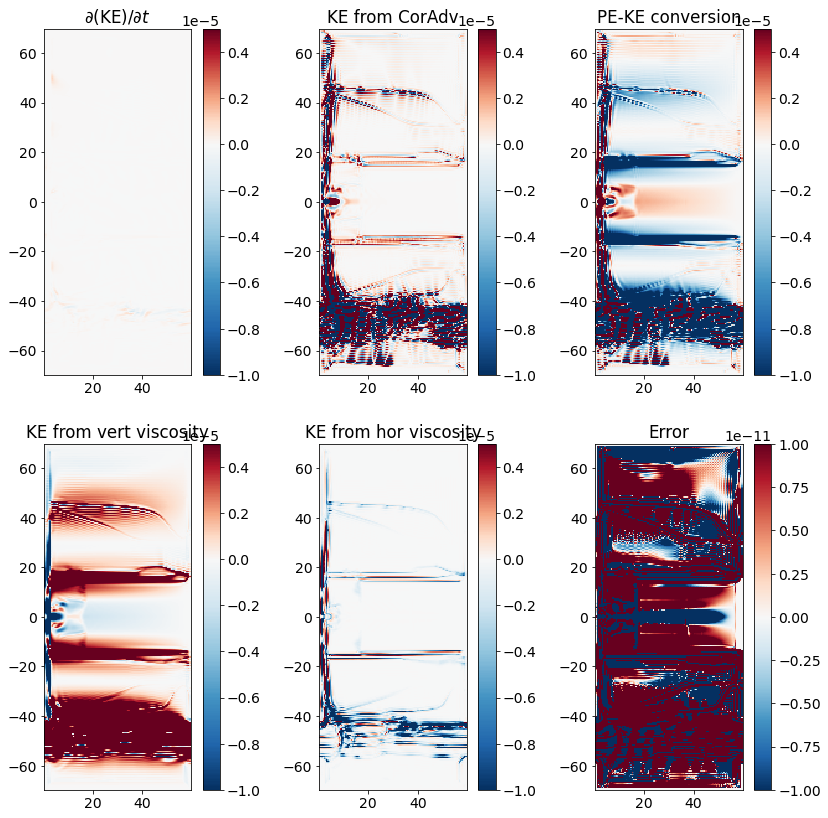

In [27]:
plt.figure(figsize=(14,14))


cmin=-1e-5; cmax=.5e-5;
plt.subplot(2,3,1)
plt.pcolormesh(xh,yh,KEterm1,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'$\partial ($KE$)/\partial t$')
plt.colorbar()

plt.subplot(2,3,2)
plt.pcolormesh(xh,yh,KEterm2,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from CorAdv')
plt.colorbar()

plt.subplot(2,3,3)
plt.pcolormesh(xh,yh,(KEterm3+KEterm4),norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'PE-KE conversion')
plt.colorbar()


plt.subplot(2,3,4)
plt.pcolormesh(xh,yh,KEterm5,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from vert viscosity')
plt.colorbar()

plt.subplot(2,3,5)
plt.pcolormesh(xh,yh,KEterm6,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=cmin,vmax=cmax)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'KE from hor viscosity')
plt.colorbar()

plt.subplot(2,3,6)
plt.pcolormesh(xh,yh,E,norm=MidpointNormalize(midpoint=0.),cmap='RdBu_r',vmin=-1e-11,vmax=1e-11)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(r'Error')

plt.colorbar()

In [20]:
KEterm1.shape

(280, 120)

In [21]:
plt.rc('font', size=14)
plt.figure(figsize=(10, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh[lat1:lat2],KEterm1.mean(axis=1),'-',c='#117733',linewidth=2)
plt.plot(yh[lat1:lat2],KEterm2.mean(axis=1),'-',c='#44AA99',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm3+KEterm4).mean(axis=1),'-',c='#999933',linewidth=2)
plt.plot(yh[lat1:lat2],(KE_stress).mean(axis=1),'-',c='#332288',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm5-KE_stress).mean(axis=1),'-',c='#CC6677',linewidth=2)

plt.plot(yh[lat1:lat2],(KEterm6).mean(axis=1),'-',c='#882255',linewidth=2)
plt.plot(yh[lat1:lat2],E.mean(axis=1),':',c='k',linewidth=2)


plt.grid()

plt.legend(['Time tendency','Advection','Conversion','Wind stress','Vert. dissipation','Hor. dissipation','Residual'],loc='lower right',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-20,70);# plt.xticks(fontsize=14); 
plt.ylim(-2.5e-5,2.5e-5); 
plt.yticks(fontsize=14)

#plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('Outside ACC',fontsize=14)




NameError: name 'lat1' is not defined

<Figure size 1000x400 with 0 Axes>

Text(0.5, 1.0, 'Eastern ACC')

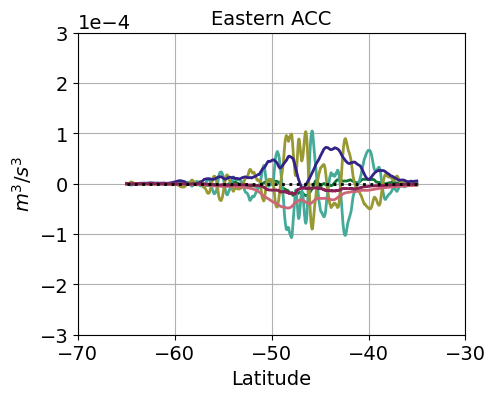

In [49]:
plt.rc('font', size=14)
plt.figure(figsize=(5, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh[lat1:lat2],KEterm1.mean(axis=1),'-',c='#117733',linewidth=2)
plt.plot(yh[lat1:lat2],KEterm2.mean(axis=1),'-',c='#44AA99',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm3+KEterm4).mean(axis=1),'-',c='#999933',linewidth=2)
plt.plot(yh[lat1:lat2],(KE_stress).mean(axis=1),'-',c='#332288',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm5-KE_stress).mean(axis=1),'-',c='#CC6677',linewidth=2)

plt.plot(yh[lat1:lat2],(KEterm6).mean(axis=1),'-',c='#882255',linewidth=2)
plt.plot(yh[lat1:lat2],E.mean(axis=1),':',c='k',linewidth=2)


plt.grid()

#plt.legend(['Time tendency','Advection','Conversion','Wind stress','Vert. dissipation','Hor. dissipation','Residual'],loc='lower right',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-70,-30);# plt.xticks(fontsize=14); 
plt.ylim(-3.e-4,3.e-4); 
plt.yticks(fontsize=14)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('Eastern ACC',fontsize=14)


In [24]:
lat2

540

Text(0.5, 1.0, 'Western ACC')

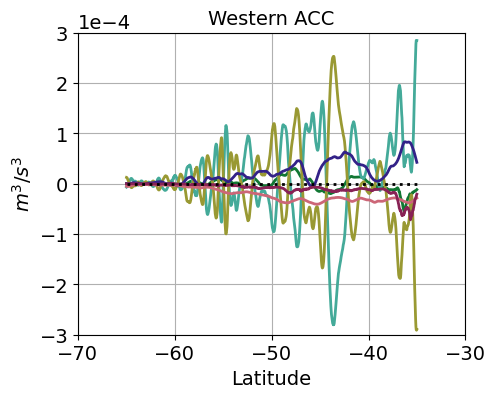

In [47]:
plt.rc('font', size=14)
plt.figure(figsize=(5, 4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(yh[lat1:lat2],KEterm1.mean(axis=1),'-',c='#117733',linewidth=2)
plt.plot(yh[lat1:lat2],KEterm2.mean(axis=1),'-',c='#44AA99',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm3+KEterm4).mean(axis=1),'-',c='#999933',linewidth=2)
plt.plot(yh[lat1:lat2],(KE_stress).mean(axis=1),'-',c='#332288',linewidth=2)
plt.plot(yh[lat1:lat2],(KEterm5-KE_stress).mean(axis=1),'-',c='#CC6677',linewidth=2)

plt.plot(yh[lat1:lat2],(KEterm6).mean(axis=1),'-',c='#882255',linewidth=2)
plt.plot(yh[lat1:lat2],E.mean(axis=1),':',c='k',linewidth=2)


plt.grid()

#plt.legend(['Time tendency','Advection','Conversion','Wind stress','Vert. dissipation','Hor. dissipation','Residual'],loc='lower right',fontsize=10)
#plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
plt.xlim(-70,-30);# plt.xticks(fontsize=14); 
plt.ylim(-3.e-4,3.e-4); 
plt.yticks(fontsize=14)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Latitude',fontsize=14)
plt.ylabel('$m^3/s^3$',fontsize=14)
plt.title('Western ACC',fontsize=14)

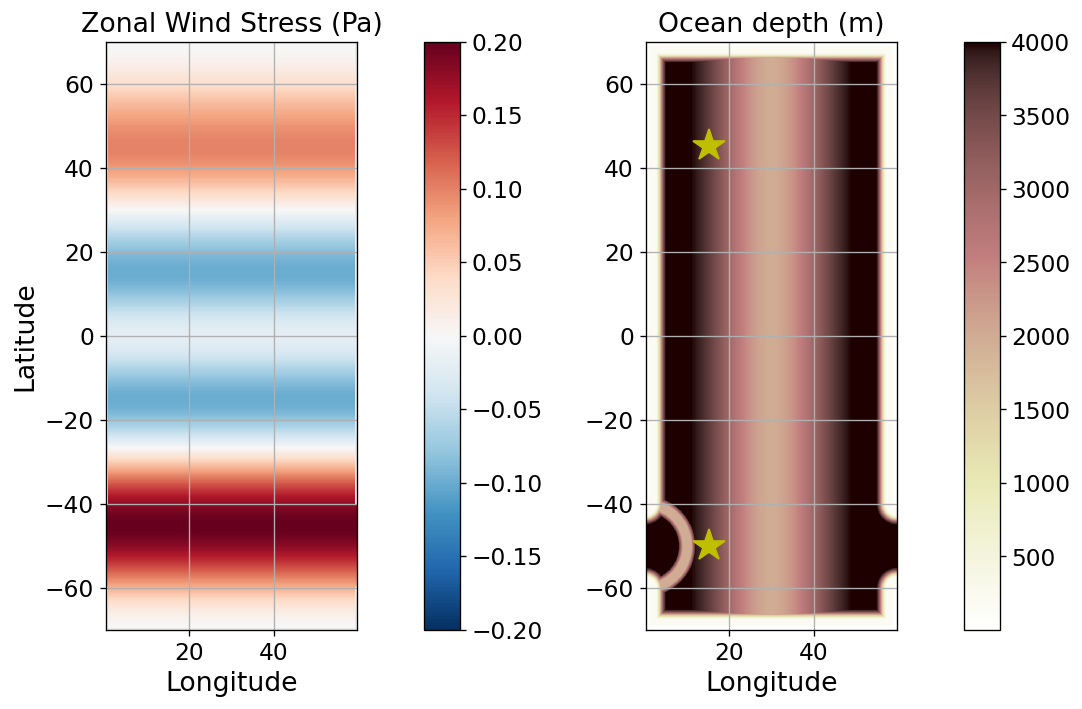

In [9]:
#Plotting zonal wind forcing (taux)
taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
fig = plt.figure(figsize=(10, 7), dpi=120, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.3,0.7]) #left, bottom, width, height
ax2 = fig.add_axes([.46, 0.2, 0.03, 0.7])

ax3 = fig.add_axes([0.6,0.2,0.3,0.7])
ax4 = fig.add_axes([.91, 0.2, 0.03, 0.7])

ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Zonal Wind Stress (Pa)',fontsize=16)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=14); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,taux,cmap='RdBu_r',vmin=-0.2,vmax=0.2)
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plotted =ax3.pcolor(xh,yh,depth,cmap='pink_r')
ax3.plot(xh[240],yh[1840],'*',Markersize=20,color='y')
ax3.plot(xh[240],yh[320],'*',Markersize=20,color='y')
ax3.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax4, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax3.set_title('Ocean depth (m)',fontsize=16)
ax3.set_xlabel('Longitude',fontsize=16)

ax3.tick_params(labelsize=14); 
ax4.tick_params(labelsize=14)
ax1.grid('on')
ax3.grid('on')
plt.show()
#fig.savefig('taux.png')

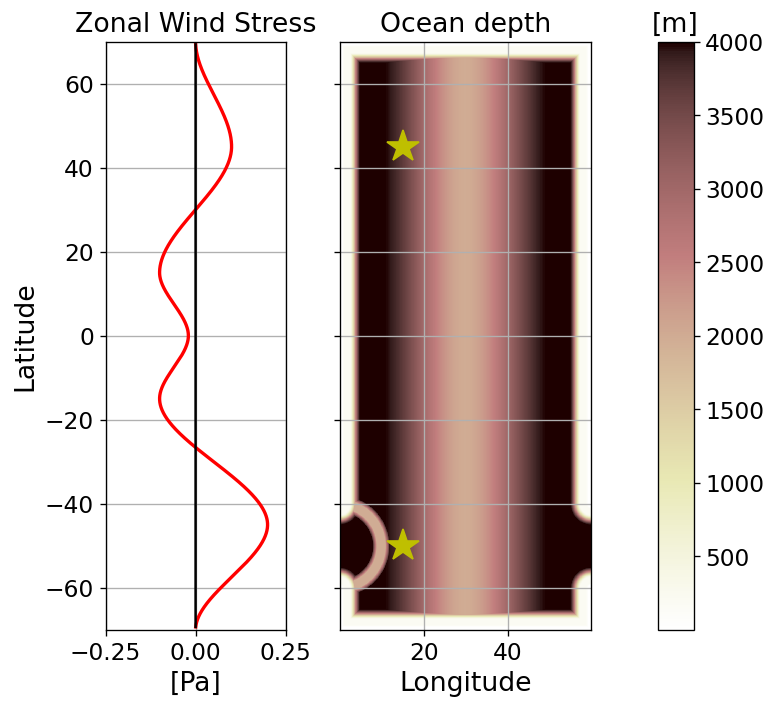

In [35]:
#Plotting zonal wind forcing (taux)
taux= forcing.taux.values[0,:,:]; taux=(taux[:,1:]+taux[:,:-1])/2.
fig = plt.figure(figsize=(10, 7), dpi=120, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.15,0.7]) #left, bottom, width, height
#ax2 = fig.add_axes([.46, 0.2, 0.03, 0.7])

ax3 = fig.add_axes([0.3,0.2,0.3,0.7])
ax4 = fig.add_axes([.61, 0.2, 0.03, 0.7])

ax1.set_title('Zonal Wind Stress',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.set_xlabel('[Pa]',fontsize=16)

ax1.tick_params(labelsize=14); 
ax1.set_xlim([-0.25,.25])
ax1.set_ylim([-70,70])
plotted =ax1.plot(taux[:,100],yh,'r',linewidth=2)
plotted =ax1.plot(taux[:,100]*0,yh,'k')



#
plotted =ax3.pcolor(xh,yh,depth,cmap='pink_r')
ax3.plot(xh[240],yh[1840],'*',Markersize=20,color='y')
ax3.plot(xh[240],yh[320],'*',Markersize=20,color='y')
ax3.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax4, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
ax3.set_title('Ocean depth',fontsize=16)
ax4.set_title('[m]',fontsize=16)
ax3.set_xlabel('Longitude',fontsize=16)
ax3.axes.yaxis.set_ticklabels([])

ax3.set_ylim([-70,70])
ax3.tick_params(labelsize=14); 
ax4.tick_params(labelsize=14)
ax1.grid('on')
ax3.grid('on')
plt.show()
#fig.savefig('taux.png')

(960,)

In [23]:
yh.shape

(2240,)

In [ ]:
#Picking out boxes to plot KE budgets for. Will plot area sum of weighted time-mean over 500 days after summing vertically
#Boxes with indexes shown for 1/4 degree:
#A: 40 to 50 lat (440:480); 15 to 45 lon (60:180)
#B: 20 to 40 lat (360:440); 15 to 45 lon (60:180)
#C: -60 to -30 lat (40:160); 15 to 45 lon (60:180)


In [105]:
#Isolating boxes

boxlat = np.arange(1760,1920)
boxlon = np.arange(240,720)

KEterm1 = np.nansum(np.array(av['dKE_dt'][:,:,boxlat,boxlon]),axis=1)
#assuming all of these are on the RHS of the KE equation
KEterm2 = np.nansum(np.array(av['KE_CorAdv'][:,:,boxlat,boxlon]),axis=1)
KEterm3 = np.nansum(np.array(av['PE_to_KE'][:,:,boxlat,boxlon]),axis=1)
KEterm4 = np.nansum(np.array(av['KE_BT'][:,:,boxlat,boxlon]),axis=1)
KEterm5 = np.nansum(np.array(av['KE_visc'][:,:,boxlat,boxlon]),axis=1)
KEterm6 = np.nansum(np.array(av['KE_horvisc'][:,:,boxlat,boxlon]),axis=1)


KEterm1 = np.nanmean(KEterm1,axis=0);
KEterm2 = np.nanmean(KEterm2,axis=0);
KEterm3 = np.nanmean(KEterm3,axis=0);
KEterm4 = np.nanmean(KEterm4,axis=0);
KEterm5 = np.nanmean(KEterm5,axis=0);
KEterm6 = np.nanmean(KEterm6,axis=0);

E = KEterm1-KEterm2-KEterm3-KEterm4-KEterm5-KEterm6 #residual term between dKE/dt and RHS of equation
area_box = area_t[np.ix_(boxlat,boxlon)]
print(KEterm1.shape,area_box.shape)

(160, 480) (160, 480)


In [106]:
boxterm1 = np.nansum(KEterm1*area_box/np.nansum(area_box))
boxterm2 = np.nansum(KEterm2*area_box/np.nansum(area_box))
boxterm34= np.nansum((KEterm3+KEterm4)*area_box/np.nansum(area_box))
boxterm5 = np.nansum(KEterm5*area_box/np.nansum(area_box))
boxterm6 = np.nansum(KEterm6*area_box/np.nansum(area_box))
boxerror = np.nansum(E*area_box/np.nansum(area_box))

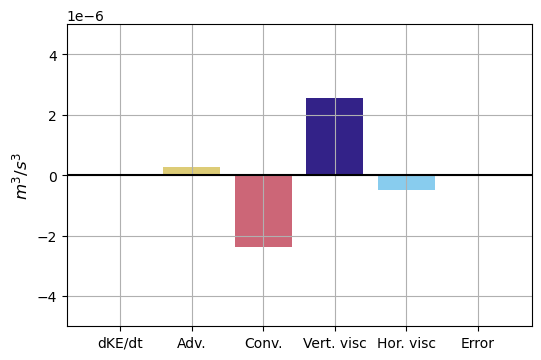

In [107]:
#plt.figure(figsize=(16, 6), dpi= 100, facecolor='w', edgecolor='k')


fig, ax1 = plt.subplots(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')

# plt.grid()
# plt.legend(['Time tendency','Advection','Conversion','Vert. visc','Hor. visc','Residual'],loc='upper right',fontsize=12)
# plt.plot([0, 0],[-100, 100],'--',color=[0,0,0])
# plt.xlim(-20, 70)
# plt.ylim(-1e-5,1e-5);
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.xlabel('Latitude',fontsize=12)
plt.ylabel('$m^3/s^3$',fontsize=12)
# plt.title('1/4$^\circ$ KE budget terms',fontsize=14)




# create a dataset
height = [boxterm1, boxterm2, boxterm34, boxterm5, boxterm6, boxerror]
bars = ('dKE/dt', 'Adv.', 'Conv.', 'Vert. visc', 'Hor. visc', 'Error')
x_pos = np.arange(len(bars))

# Create bars with different colors
ax1.plot([-1,6],[0,0], 'k')
ax1.bar(x_pos, height, color = ['#117733','#ddcc77','#cc6677','#332288','#88ccee','k'])

ax1.plot([])
ax1.set_xlim([-0.75,5.75])
ax1.set_ylim([-5e-6,5e-6])

# Create names on the x-axis
plt.xticks(x_pos, bars)
plt.grid('on')
# Show graph
plt.show()

In [65]:

# TO WRITE AND READ e_calculated:

#%rm e_calculated.nc
# written_ds = nc.Dataset('e_calculated.nc', 'w', format='NETCDF4')

# timef = written_ds.createDimension('timef', 100)
# latf = written_ds.createDimension('latf',len(yh) )
# lonf = written_ds.createDimension('lonf', len(xh))
# layerf = written_ds.createDimension('layerf', 15)

# e = written_ds.createVariable('e', 'f4', ('timef', 'layerf', 'latf', 'lonf',))

# e[:,:, :, :] = e_calculated
# written_ds.close()
# reading_e = xr.open_dataset('test.nc')
# print(reading_e)
# e_calculated = reading_e['e']

#np.nanmean(e_calculated)
#e2 and e2_calculated are roughly the same, just e2_calculated using 5-day averaged h outputs. 